# 1.1-DVR-Research-TrendScanning

Trend Scanning is not a trading model in itself, but extended to form a model

Ideas for a trading model:
- Classify trend for recent history.  If probability of "long" is > 50% and your entry signal is long, enter.  Exit with your favorite stop loss method.
- Classify trend for two products, e.g. S&P and Gold.  Enter on S&P crossover, exit when Gold trend changes
- Use "t1" output as a feature for meta-labeling (i.e. a lagged trend as a feature)

Machine Learning for Asset Management by MLdP
- SNIPPET 5.1 T-VALUE OF A LINEAR TREND
- SNIPPET 5.2 IMPLEMENTATION OF THE TREND-SCANNING METHOD

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# trendscanning
import sys
sys.path.append("..")
import decisiveml as dml

## Generate Data
- I'm using CL data from the first half of 2019
- If data is not available, we'll generate a random price history

In [2]:
try:
    import dvmaster as dvm
except ModuleNotFoundError:
    raw_frame = pd.DataFrame(index=pd.date_range("2018-12-01", "2019-07-01"))
    raw_frame["equity"] = (np.random.randn(raw_frame.shape[0])/100).cumsum()
    raw_frame["close"] = 48.76 * (1 + raw_frame["equity"])
else:
    raw_frame = dvm.dtn_frame_from_symbol("CL", dstype="historical", suffix="D", devfdpath="../data/dtn",)
    
print(f"Loaded raw_frame from {raw_frame.index[0]} to {raw_frame.index[-1]}")

Loaded raw_frame from 2018-12-01 00:00:00 to 2019-07-01 00:00:00


## Generate Events
- We'll use a moving average cross-over.  
- Since I do both above or below, could get noisy but I'm interesting in watching the trend scanning work
- You may try running above or below only to see how it looks

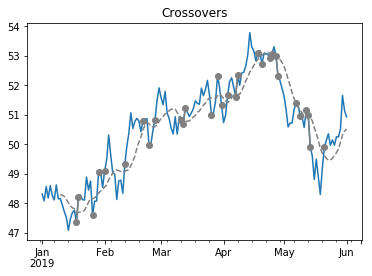

In [3]:
df = raw_frame["2019-01-01":"2019-06-01"].copy()

# signal
df["mavg"] = df.close.rolling(10).mean()
m_crossabove = (df.close.shift(1) < df.mavg) & (df.close > df.mavg)
m_crossbelow = (df.close.shift(1) > df.mavg) & (df.close < df.mavg)
df["entry"] = df[m_crossabove | m_crossbelow].close

# plot
df.close.plot()
df.mavg.plot(linestyle="--", color="gray")
df.entry.plot(marker="o", color="gray")
plt.title("Crossovers");

## Execute Trend Scanning
- Check the trend for lookforward of 1-week, 2-weeks, 3-weeks, 4-weeks
- Notice that if the best t-value is the longer lookforward, any intermediate entry is discarded

In [4]:
trend = dml.getBinsFromTrend(
    molecule=df["entry"].dropna().index, 
    close=df.close, 
    span=[22, 44, 11],
)
trend

,t1,tVal,bin
2019-01-18,2019-02-19,7.56624,1.0
2019-01-19,2019-02-20,7.50562,1.0
2019-01-26,2019-02-27,7.65391,1.0
2019-01-29,2019-03-02,7.408,1.0
2019-02-01,2019-03-05,6.97495,1.0
2019-02-11,2019-03-15,3.98969,1.0
2019-02-20,2019-03-24,3.33004,1.0
2019-02-23,2019-03-27,2.95752,1.0
2019-02-26,2019-03-30,2.46085,1.0
2019-03-11,2019-04-12,5.27971,1.0


## Visualize

In [5]:
# add trend to the frame and ffill
df["trend"] = trend.bin
end = trend.t1
df.loc[end, "trend"] = 0
df.trend.fillna(method="ffill", inplace=True)
df.trend.fillna(0, inplace=True)

# get the unfiltered trends
df["trendstart"] = df[(df.trend != 0) & (df.trend.shift(1) == 0)].close
df["trendend"] = df[(df.trend == 0) & (df.trend.shift(1) != 0)].close

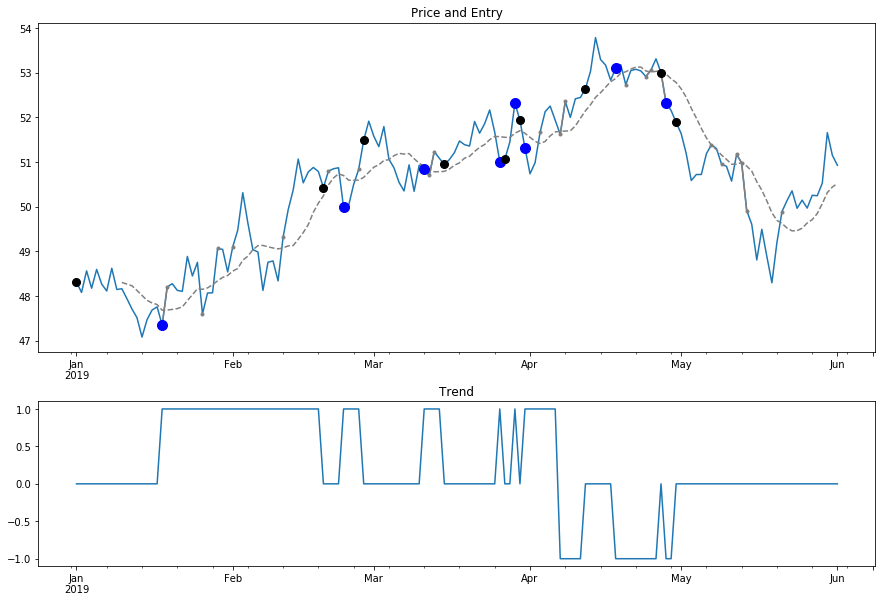

In [6]:
# plots
fig, axes = plt.subplots(nrows=2, ncols=1, 
                         figsize=(15,10), 
                         gridspec_kw={'height_ratios': [2,1]})

df.close.plot(ax=axes[0])
df.mavg.plot(ax=axes[0], color="gray", linestyle="--")
df.entry.plot(ax=axes[0], marker=".", color="gray")
df.trendstart.plot(ax=axes[0], marker="o", markersize=10, color="blue")
df.trendend.plot(ax=axes[0], marker="o", markersize=8, color="black")

df.trend.plot(ax=axes[1])

axes[0].title.set_text('Price and Entry')
axes[1].title.set_text('Trend')